In [ ]:
import pandas as pd
import numpy as np
import re
import nltk

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder, StandardScaler, MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer


In [ ]:
data = pd.read_csv('/content/AI_Resume_Screening.csv')
data.head()

,Resume_ID,Name,Skills,Experience (Years),Education,Certifications,Job Role,Recruiter Decision,Salary Expectation ($),Projects Count,AI Score (0-100)
0,1,Ashley Ali,"TensorFlow, NLP, Pytorch",10,B.Sc,NaN,AI Researcher,Hire,104895,8,100
1,2,Wesley Roman,"Deep Learning, Machine Learning, Python, SQL",10,MBA,Google ML,Data Scientist,Hire,113002,1,100
2,3,Corey Sanchez,"Ethical Hacking, Cybersecurity, Linux",1,MBA,Deep Learning Specialization,Cybersecurity Analyst,Hire,71766,7,70
3,4,Elizabeth Carney,"Python, Pytorch, TensorFlow",7,B.Tech,AWS Certified,AI Researcher,Hire,46848,0,95
4,5,Julie Hill,"SQL, React, Java",4,PhD,NaN,Software Engineer,Hire,87441,9,100


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Resume_ID               1000 non-null   int64 
 1   Name                    1000 non-null   object
 2   Skills                  1000 non-null   object
 3   Experience (Years)      1000 non-null   int64 
 4   Education               1000 non-null   object
 5   Certifications          726 non-null    object
 6   Job Role                1000 non-null   object
 7   Recruiter Decision      1000 non-null   object
 8   Salary Expectation ($)  1000 non-null   int64 
 9   Projects Count          1000 non-null   int64 
 10  AI Score (0-100)        1000 non-null   int64 
dtypes: int64(5), object(6)
memory usage: 86.1+ KB


# ***Pre-Processing***

In [ ]:
data.isnull().sum()

,0
Resume_ID,0
Name,0
Skills,0
Experience (Years),0
Education,0
Certifications,274
Job Role,0
Recruiter Decision,0
Salary Expectation ($),0
Projects Count,0


In [ ]:
data['Skills'] = data['Skills'].str.lower()


In [ ]:
import string
data['Skills'] = data['Skills'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))


In [ ]:
data['Skills'] = data['Skills'].apply(lambda x: ''.join([char for char in x if not char.isdigit()]))


In [ ]:
data['Skills'] = data['Skills'].apply(lambda x: ' '.join(x.split()))


In [ ]:
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
data['Skills'] = data['Skills'].apply(nltk.word_tokenize)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [ ]:
from nltk.corpus import stopwords
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))
data['Skills'] = data['Skills'].apply(lambda tokens: [w for w in tokens if w not in stop_words])


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()
data['Skills'] = data['Skills'].apply(lambda tokens: [lemmatizer.lemmatize(w) for w in tokens])


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# ***Implement TF-IDF + Cosine similarity***

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
data = pd.read_csv('/content/AI_Resume_Screening.csv')
job_descriptions = {
    "AI Researcher": "Looking for an AI Researcher skilled in deep learning, machine learning, TensorFlow, PyTorch, NLP, and research publications.",
    "Data Scientist": "Seeking a Data Scientist with expertise in data analysis, Python, SQL, machine learning, and visualization tools like Tableau or PowerBI.",
    "Cybersecurity Analyst": "Hiring a Cybersecurity Analyst experienced in ethical hacking, cybersecurity tools, network defense, and Linux systems.",
    "Software Engineer": "We need a Software Engineer proficient in software development, Java, React, SQL, system design, and debugging."
}
data['resume_text'] = (
    data['Skills'].fillna('') + ', ' +
    data['Certifications'].fillna('') + ', ' +
    data['Education'].fillna('')
)

data['job_description'] = data['Job Role'].map(job_descriptions)

all_texts = pd.concat([data['resume_text'], data['job_description']], axis=0)
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(all_texts)
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())

resume_vecs = tfidf_matrix[:len(data)]
job_vecs = tfidf_matrix[len(data):]
resume_tfidf_df = tfidf_df.iloc[:len(data)]
job_tfidf_df = tfidf_df.iloc[len(data):]

similarity_scores = [
    cosine_similarity(resume_vecs[i], job_vecs[i])[0][0]
    for i in range(len(data))
]
print("TF-IDF Matrix for Resumes:")
print(resume_tfidf_df)

print("\nTF-IDF Matrix for Job Descriptions:")
print(job_tfidf_df)

data['Resume-Job Match Score'] = similarity_scores
print(data[['Name', 'Job Role', 'Resume-Job Match Score']])
top_5_matches = data.sort_values(by='Resume-Job Match Score', ascending=False).head(5)

print("\nTop 5 Resume-Job Matches:")
print(top_5_matches[['Name', 'Job Role', 'Resume-Job Match Score']])



TF-IDF Matrix for Resumes:
      ai  analysis  analyst       aws  certified  cybersecurity  data  \
0    0.0       0.0      0.0  0.000000   0.000000       0.000000   0.0   
1    0.0       0.0      0.0  0.000000   0.000000       0.000000   0.0   
2    0.0       0.0      0.0  0.000000   0.000000       0.347407   0.0   
3    0.0       0.0      0.0  0.471535   0.471535       0.000000   0.0   
4    0.0       0.0      0.0  0.000000   0.000000       0.000000   0.0   
..   ...       ...      ...       ...        ...            ...   ...   
995  0.0       0.0      0.0  0.000000   0.000000       0.422377   0.0   
996  0.0       0.0      0.0  0.000000   0.000000       0.000000   0.0   
997  0.0       0.0      0.0  0.000000   0.000000       0.000000   0.0   
998  0.0       0.0      0.0  0.378610   0.378610       0.309117   0.0   
999  0.0       0.0      0.0  0.000000   0.000000       0.000000   0.0   

     debugging      deep  defense  ...  skilled  software  specialization  \
0          0.0  0.0

In [ ]:
data

,Resume_ID,Name,Skills,Experience (Years),Education,Certifications,Job Role,Recruiter Decision,Salary Expectation ($),Projects Count,AI Score (0-100),resume_text,job_description,Resume-Job Match Score
0,1,Ashley Ali,"TensorFlow, NLP, Pytorch",10,B.Sc,NaN,AI Researcher,Hire,104895,8,100,"TensorFlow, NLP, Pytorch, , B.Sc",Looking for an AI Researcher skilled in deep l...,0.351043
1,2,Wesley Roman,"Deep Learning, Machine Learning, Python, SQL",10,MBA,Google ML,Data Scientist,Hire,113002,1,100,"Deep Learning, Machine Learning, Python, SQL, ...",Seeking a Data Scientist with expertise in dat...,0.203587
2,3,Corey Sanchez,"Ethical Hacking, Cybersecurity, Linux",1,MBA,Deep Learning Specialization,Cybersecurity Analyst,Hire,71766,7,70,"Ethical Hacking, Cybersecurity, Linux, Deep Le...",Hiring a Cybersecurity Analyst experienced in ...,0.417987
3,4,Elizabeth Carney,"Python, Pytorch, TensorFlow",7,B.Tech,AWS Certified,AI Researcher,Hire,46848,0,95,"Python, Pytorch, TensorFlow, AWS Certified, B....",Looking for an AI Researcher skilled in deep l...,0.193419
4,5,Julie Hill,"SQL, React, Java",4,PhD,NaN,Software Engineer,Hire,87441,9,100,"SQL, React, Java, , PhD",We need a Software Engineer proficient in soft...,0.295518
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,996,Brenda Williams,"Cybersecurity, Linux, Ethical Hacking",0,B.Sc,NaN,Cybersecurity Analyst,Reject,114364,9,60,"Cybersecurity, Linux, Ethical Hacking, , B.Sc",Hiring a Cybersecurity Analyst experienced in ...,0.508189
996,997,Colleen Hicks,"Deep Learning, Machine Learning",0,MBA,Deep Learning Specialization,Data Scientist,Reject,103294,5,45,"Deep Learning, Machine Learning, Deep Learning...",Seeking a Data Scientist with expertise in dat...,0.137809
997,998,Michelle Molina,"TensorFlow, NLP",0,B.Tech,Google ML,AI Researcher,Hire,113855,9,65,"TensorFlow, NLP, Google ML, B.Tech",Looking for an AI Researcher skilled in deep l...,0.199985
998,999,Danielle Horn,"Linux, Networking, Cybersecurity, Ethical Hacking",8,PhD,AWS Certified,Cybersecurity Analyst,Hire,83146,10,100,"Linux, Networking, Cybersecurity, Ethical Hack...",Hiring a Cybersecurity Analyst experienced in ...,0.371919


**Visualizatons**

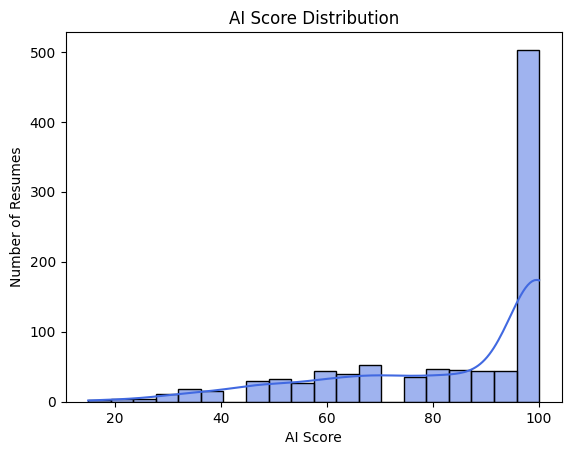

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.histplot(data["AI Score (0-100)"], bins=20, kde=True, color='royalblue')
plt.title("AI Score Distribution")
plt.xlabel("AI Score")
plt.ylabel("Number of Resumes")
plt.show()


<ipython-input-15-a4d2eed41643>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x="Recruiter Decision", palette="Set2")


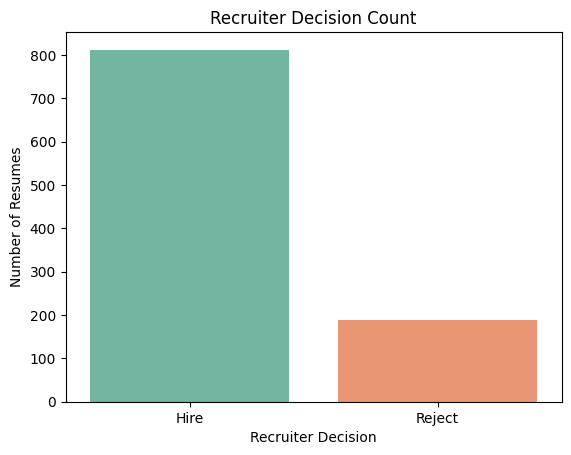

In [ ]:
sns.countplot(data=data, x="Recruiter Decision", palette="Set2")
plt.title("Recruiter Decision Count")
plt.xlabel("Recruiter Decision")
plt.ylabel("Number of Resumes")
plt.show()


<ipython-input-16-226167f3a644>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_ai_by_role.values, y=avg_ai_by_role.index, palette="viridis")


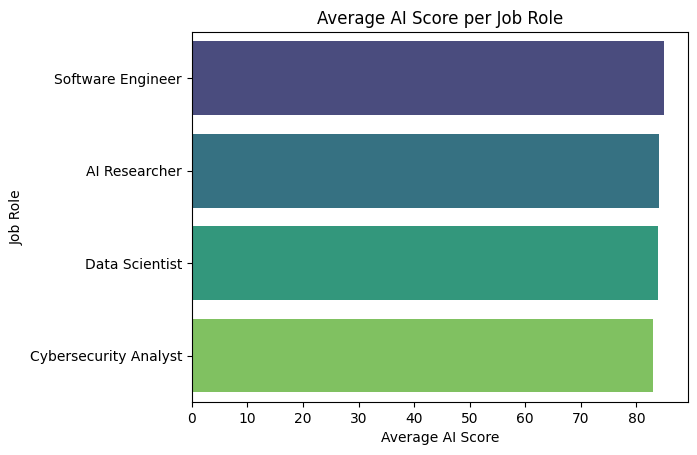

In [ ]:
avg_ai_by_role = data.groupby("Job Role")["AI Score (0-100)"].mean().sort_values(ascending=False)
sns.barplot(x=avg_ai_by_role.values, y=avg_ai_by_role.index, palette="viridis")
plt.title("Average AI Score per Job Role")
plt.xlabel("Average AI Score")
plt.ylabel("Job Role")
plt.show()


<ipython-input-17-447dd3b6aae5>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_salary_by_role.values, y=avg_salary_by_role.index, palette="cubehelix")


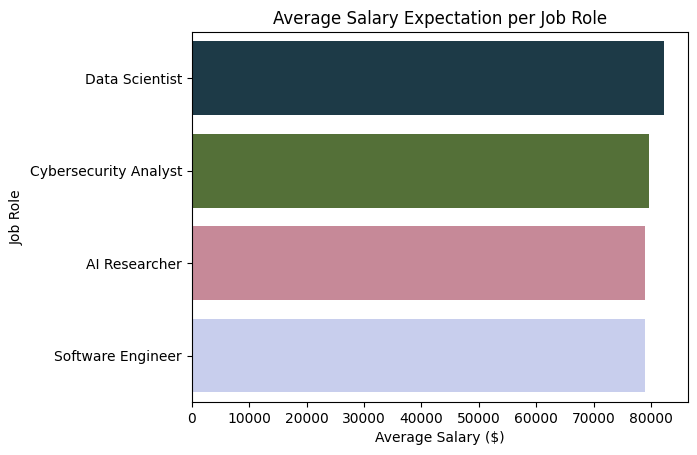

In [ ]:
avg_salary_by_role = data.groupby("Job Role")["Salary Expectation ($)"].mean().sort_values(ascending=False)
sns.barplot(x=avg_salary_by_role.values, y=avg_salary_by_role.index, palette="cubehelix")
plt.title("Average Salary Expectation per Job Role")
plt.xlabel("Average Salary ($)")
plt.ylabel("Job Role")
plt.show()



<ipython-input-18-7ef6be09d3fa>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Count", y="Skill", data=top_skills, palette="mako")


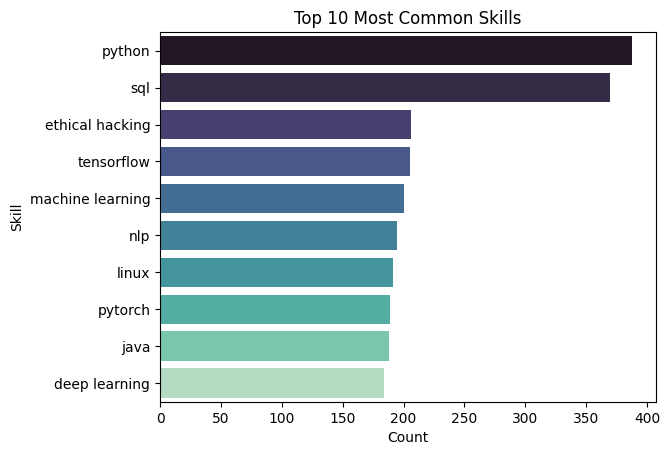

In [ ]:
from collections import Counter

# Combine all skills into one long string
all_skills = data["Skills"].dropna().str.lower().str.split(',').sum()
skill_counts = Counter([skill.strip() for skill in all_skills])

# Convert to DataFrame
top_skills = pd.DataFrame(skill_counts.most_common(10), columns=['Skill', 'Count'])

# Plot
sns.barplot(x="Count", y="Skill", data=top_skills, palette="mako")
plt.title("Top 10 Most Common Skills")
plt.xlabel("Count")
plt.ylabel("Skill")
plt.show()


# Random Forest Model


In [ ]:
data['Certifications'] = data['Certifications'].fillna('None')
data['Has_Certification'] = data['Certifications'].apply(lambda x: 0 if x == 'None' else 1)


In [ ]:
label_enc = LabelEncoder()

data['Education'] = label_enc.fit_transform(data['Education'])
data['Recruiter Decision'] = data['Recruiter Decision'].map({'Hire': 1, 'Reject': 0})
data['Job Role'] = label_enc.fit_transform(data['Job Role'])



In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics.pairwise import cosine_similarity


X = data[['Resume-Job Match Score' , 'Experience (Years)' , 'Salary Expectation ($)' , 'Projects Count'  ]]

y = data['Recruiter Decision']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Train Random Forest
modelrf = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=5, random_state=42)
modelrf.fit(X_train, y_train)

# Predict and evaluate
y_pred = modelrf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.965

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.96      0.93        46
           1       0.99      0.97      0.98       154

    accuracy                           0.96       200
   macro avg       0.94      0.96      0.95       200
weighted avg       0.97      0.96      0.97       200



In [ ]:
# New candidate data (as a DataFrame)
new_candidaterf = pd.DataFrame([{
    'Resume-Job Match Score': 0.90,
    'Experience (Years)': 5,
    'Salary Expectation ($)': 85000,
    'Projects Count': 5
}])

# Prediction
prediction = modelrf.predict(new_candidaterf)
print("Prediction:", "Hire" if prediction[0] == 1 else "Reject")


Prediction: Hire


# **LogisticRegression Model**

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score


X = data[['Resume-Job Match Score', 'Experience (Years)', 'Salary Expectation ($)', 'Projects Count']]
y = data['Recruiter Decision']  # Target variable

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# Train Logistic Regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# New candidate prediction
new_candidate = pd.DataFrame([{
    'Resume-Job Match Score': 0.10,
    'Experience (Years)': 1,
    'Salary Expectation ($)': 85000,
    'Projects Count': 1
}])

prediction = model.predict(new_candidate)
print("Prediction for new candidate:", "Hire ✅" if prediction[0] == 1 else "Reject ❌")


Accuracy: 0.9733333333333334

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.98      0.94        64
           1       1.00      0.97      0.98       236

    accuracy                           0.97       300
   macro avg       0.95      0.98      0.96       300
weighted avg       0.98      0.97      0.97       300

Prediction for new candidate: Reject ❌


In [ ]:
# Example new candidate
new_candidate = pd.DataFrame([{
    'Resume-Job Match Score': 0.90,
    'Experience (Years)': 3,
    'Salary Expectation ($)': 60000,
    'Projects Count': 5
}])

# Make prediction
prediction = model.predict(new_candidate)
print("Prediction for new candidate:", "Hire ✅" if prediction[0] == 1 else "Reject ❌")


Prediction for new candidate: Hire ✅


# *HYPERPARAMETER* *TUNING*

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report


In [ ]:
rf = RandomForestClassifier(random_state=42)

rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

rf_grid = GridSearchCV(estimator=rf, param_grid=rf_param_grid,
                       cv=5, n_jobs=-1, verbose=1, scoring='accuracy')

rf_grid.fit(X_train, y_train)

print("Best RF Parameters:", rf_grid.best_params_)
print("RF Test Accuracy:", rf_grid.score(X_test, y_test))


Fitting 5 folds for each of 162 candidates, totalling 810 fits
Best RF Parameters: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 300}
RF Test Accuracy: 0.9633333333333334


In [ ]:
logreg = LogisticRegression(solver='liblinear', max_iter=1000)

logreg_param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2']
}

logreg_grid = GridSearchCV(estimator=logreg, param_grid=logreg_param_grid,
                           cv=5, n_jobs=-1, verbose=1, scoring='accuracy')

logreg_grid.fit(X_train, y_train)

print("Best LR Parameters:", logreg_grid.best_params_)
print("LR Test Accuracy:", logreg_grid.score(X_test, y_test))


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best LR Parameters: {'C': 10, 'penalty': 'l1'}
LR Test Accuracy: 0.9733333333333334
